In [1]:
%%time
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Import Modules
import datetime
import itertools
#import graphviz
import keras
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
import tensorflow as tf
import warnings
import xgboost

# Other Imports
from matplotlib import rcParams, gridspec
from xgboost import XGBClassifier

# Keras Imports
from keras import models, layers
from keras import regularizers
from keras.models import Model, load_model, Sequential
from keras.layers import Input, Dense, Dropout, Embedding
from keras.wrappers.scikit_learn import KerasClassifier


# Preprocesing
from sklearn.decomposition import PCA
from sklearn.externals import joblib
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.preprocessing import StandardScaler

# Sklearn Models
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.covariance import EllipticEnvelope
from sklearn.pipeline import make_pipeline
from sklearn.utils.class_weight import compute_sample_weight

# Metrics
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report,
                             f1_score, precision_score, recall_score,
                             precision_recall_fscore_support, roc_auc_score)

# Model Selection
from sklearn.model_selection import (cross_val_score, KFold, train_test_split,
                                     GridSearchCV, cross_validate,
                                     StratifiedKFold)

# Set Numpy and Python Random Seed
seed = 7
np.random.seed(seed)

# Pandas Configuration
pd.set_option('max_columns', 1000)
pd.set_option('max_rows', 100)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Warning Configuration
warnings.filterwarnings('ignore')

# Plotting Configuration
rcParams['figure.figsize'] = (12.0, 4.0)
rcParams.update({'font.size': 10})
colors = ['#74a9cf', '#6a51a3']

# Print versions of each package above 
print("Numpy version: {}".format(np.__version__))
print("Pandas version: {}".format(pd.__version__))
print("Sklearn version: {}".format(sklearn.__version__))
print("Keras version: {}".format(keras.__version__))
print("XBG Boost version: {}".format(xgboost.__version__))

Using TensorFlow backend.
C:\Users\19145\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\19145\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\19145\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\19145\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py

Numpy version: 1.17.3
Pandas version: 0.23.4
Sklearn version: 0.20.3
Keras version: 2.3.1
XBG Boost version: 0.90
Wall time: 35.5 s


In [2]:
def anon_to_target(array):
    '''
    Converts Prediction in the +1/-1 format to 0/1 format for every value in the array

    Parameter
    ---------
    array: numpy array containing only +1/1

    Exmaples
    ---------
    >>>> anon_to_targets([1,1,,1,1,-1,1,-1,1])
    '''

    array = [0 if i == 1 else 1 for i in array]
    array = np.array(array).reshape(1, -1)[0]

    return array


def grid_search_groupby(results: pd.DataFrame, param_1: str, param_2: str) -> pd.DataFrame:
    '''
    Create a aggregated dataframe from the grid search results use the two
    hyper paramters that we pass into the function. We will be using this
    function to plot heatmaps from our grid search.

    Parameters
    ----------
    results: DataFrame of Grid Score results.

    Examples
    ----------
    >>> (grid_search_groupby(results,'max_depth','n_estimators')
    >>> grid_search_groupby(results,'max_leaf_nodes','n_estimators')
    '''
    assert (type(results) ==  type(pd.DataFrame())), 'results should be a pandas.core.frame.DataFrame'
    assert (type(param_1) == str), 'param_1 should be a string'
    assert (type(param_2) == str), 'param_2 should be a string'

    params_df  = pd.DataFrame.from_dict(list(results.params.values))
    mean_test_score = results.mean_test_score
    result_shrt_df = pd.concat([mean_test_score, params_df], axis=1)
    result_shrt_df = result_shrt_df.fillna(value='None') # Fill in Default value None with string
    result_groupby = result_shrt_df.groupby([param_1, param_2])['mean_test_score'].mean().unstack()
    return result_groupby


def plot_confusion_anomoly(model, classes, name,
                           train_y, test_y, train_x,test_x,
                           cmap=plt.cm.Purples):
    '''
    Function plots a confusion matrix given train and test 
    unsuperived models

    Parameters
    ----------
    train_model: sklearn/keras model object to be trained on training data
    test_moedl: sklearn/keras model object to be trained on test data

    Examples
    ----------
    >>>> plot_confusion_anomoly(xg_model, train_x, train_y)
    >>>> plot_confusion_anomoly(rf_model, train_x, train_y)
    '''
    rcParams['figure.figsize'] = (30.0, 22.5)

    # Plot Train Confusion Matrix
    fig = gridspec.GridSpec(3,3)
    grid_length = list(range(1,3))
    tuple_grid = [(i,j) for i in grid_length for j in grid_length]

    plt.subplot2grid((3,3), (0,0))
    cm = confusion_matrix(train_y, anon_to_target(model.predict(train_x)))
    plot_confusion_matrix(cm, classes, fontsize=20, 
                          title=name,
                         normalize=True, cmap=cmap)
    
    plt.subplot2grid((3,3), (0,1))
    cm = confusion_matrix(test_y, anon_to_target(model.predict(test_x)))
    plot_confusion_matrix(cm, classes, fontsize=20,
                          title=name,
                         normalize=True, cmap=cmap);

    return None


def plot_confusion_matrix(cm, classes, fontsize=20,
                          normalize=False, title='Confusion matrix',
                          cmap=plt.cm.Blues):
    '''
    THE MAIN CONFUSION MATRIX, KAVI DON'T DELTETE BY ACCIDENT AGAIN. Function plots a 
    confusion matrix given a cm matrix and class names

    Parameters
    ----------
    cm: sklearn confusion matrix
    classes: numpy 1D array containing all unique class names

    Examples
    ---------
    >>>>

    plot_confusion_matrix(
    cm,
    classes,
    fontsize=25,
    normalize=True,
    title=model.name.capitalize() + ': Test Set',
    cmap=plt.cm.Greens)

    '''
    cm_num = cm
    cm_per = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        # print("Normalized confusion matrix")
    else:
        None
        # print('Confusion matrix, without normalization')

    # print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title.replace('_',' ').title()+'\n', size=fontsize)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size=fontsize)
    plt.yticks(tick_marks, classes, size=fontsize)

    fmt = '.5f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        # Set color parameters
        color = "white" if cm[i, j] > thresh else "black"
        alignment = "center"

        # Plot perentage
        text = format(cm_per[i, j], '.5f')
        text = text + '%'
        plt.text(j, i,
            text,
            fontsize=fontsize,
            verticalalignment='baseline',
            horizontalalignment='center',
            color=color)
        # Plot numeric
        text = format(cm_num[i, j], 'd')
        text = '\n \n' + text
        plt.text(j, i,
            text,
            fontsize=fontsize,
            verticalalignment='center',
            horizontalalignment='center',
            color=color)

    plt.tight_layout()
    plt.ylabel('True label'.title(), size=fontsize)
    plt.xlabel('Predicted label'.title(), size=fontsize)

    return None


def plot_confusion_normal(model, classes, name, train_x, train_y,
                          test_x, test_y, cmap=plt.cm.Greens):
    '''
    Fuction plota grid and calls the plot_confusion_matrix function
    to plot two confusion matrices. One for the tarin set and another
    for the test set bbbbbbbbbbb+           ?????????????????????

    Parameters
    ----------
    cm: sklearn confusion matrix
    classes: numpy 1D array containing all unique class names

    Examples
    ----------
    >>>> plot_confusion_normal(xg_model, train_x, train_y)
    >>>> plot_confusion_normal(rf_model, train_x, train_y)
    '''

    # Set the plot size
    rcParams['figure.figsize'] = (30.0, 22.5)

    # Set up grid
    plt.figure()
    fig = gridspec.GridSpec(3, 3)
    grid_length = list(range(1, 3))
    tuple_grid = [(i, j) for i in grid_length for j in grid_length]

    # Plot Training Confusion Matrix
    plt.subplot2grid((3, 3), (0, 0))
    cm = confusion_matrix(train_y, model.predict(train_x))
    plot_confusion_matrix(
        cm,
        classes=classes,
        normalize=True,
        title=name.capitalize() + ': Train Set',
        cmap=cmap)

    # Plot Testing Confusion Matrix
    plt.subplot2grid((3, 3), (0, 1))
    cm = confusion_matrix(test_y, model.predict(test_x))
    plot_confusion_matrix(
        cm,
        classes=classes,
        normalize=True,
        title=name.capitalize() + ': Test Set',
        cmap=cmap)

    return None        


def plot_confusion_neural(model, classes, train_x, train_y, 
                          test_x, test_y, cmap=plt.cm.Oranges):
    '''
    Funtion to plot a grid and calls the plot_confusion_matrix function
    to plot two confusion matrices. One for the tarin set and another
    for the test set. This function includes a sigmoid function that rounds
    networks prediction before plotting.

    Parameters
    ----------
    cm: sklearn confusion matrix
    classes: numpy 1D array containing all unique class names

    Examples
    ----------
    >>>> plot_confusion_neural(nn_model, train_x, train_y)
    >>>> plot_confusion_neural(autoencoder, train_x, train_y)
    '''

    # Set the plot size
    rcParams['figure.figsize'] = (30.0, 22.5)

    # Set up grid
    plt.figure()
    fig = gridspec.GridSpec(3, 3)
    grid_length = list(range(1, 3))
    tuple_grid = [(i, j) for i in grid_length for j in grid_length]

    # Plot Training Confusion Matrix
    plt.subplot2grid((3, 3), (0, 0))
    cm = confusion_matrix(train_y, model.predict(train_x))
    plot_confusion_matrix(
        cm,
        classes,
        fontsize=25,
        normalize=True,
        title=model.name.capitalize() + ': Train Set',
        cmap=cmap)

    # Plot Testing Confusion Matrix
    plt.subplot2grid((3, 3), (0, 1))
    cm = confusion_matrix(test_y, (model.predict(test_x)))
    plot_confusion_matrix(
        cm,
        classes,
        fontsize=25,
        normalize=True,
        title=model.name.capitalize() + ': Test Set',
        cmap=cmap)

    return None


def target_to_anon(array):
    '''
    Converts prediction in the 
    0/1 standard format to 1/-1 anomoly format for every
    value in the array

    Parameter
    ---------
    array: numpy array containing only +1/1

    Exmaples
    ---------
    >>>> anon_to_targets([1,1,,1,1,-1,1,-1,1])
    '''
    array = [1 if i == 0 else -1 for i in array]
    array = np.array(array).reshape(1,-1)[0]
    return array


def read_csv(path: str, lower=True) -> pd.DataFrame:
    '''Read in csv data return dataframe after lowering all columns name
    
    Parameters
    ----------
    path: Absolulte or Relative Path to csv data
    
    '''
    df = pd.read_csv('paysim.csv')
    if lower == True:
        df.columns = df.columns.str.lower()
    return df


# Customer summary stastitics dataframe
def sum_stat(df:pd.DataFrame) -> pd.DataFrame:
    '''
    Plot the summary statitic of a dataframe. The statistics 
    include the normal describe statistics as well as additional
    median value, and counts on the number of unique values and
    null values
    
    Parameters
    ----------
    
    df: A pandas dataframes of datate
    '''
    
    sum_df = pd.concat([df.describe(), 
           pd.DataFrame(df.nunique(), columns=['nuniques']).T,
           pd.DataFrame(np.sum(df.isnull(), axis =0), columns=['isnull']).T],
           axis=0)
    return sum_df

In [3]:
# Import paysim data
sdf = read_csv('paysim.csv')
sdf = sdf.rename(columns={'isfraud':'target', 'oldbalanceorg':'oldbalanceorig'})

# Create a holdout dataset with 50% of the data. 3 milliion+ rows each.
holdout_index = np.random.choice(np.arange(0,sdf.shape[0]), size=int(sdf.shape[0]*0.5),replace=False)
sdf_holdout = sdf[sdf.index.isin(holdout_index)]
sdf = sdf[~sdf.index.isin(holdout_index)]
sdf.head(10)

,step,type,amount,nameorig,oldbalanceorig,newbalanceorig,namedest,oldbalancedest,newbalancedest,target,isflaggedfraud
0,1,PAYMENT,9839.640,C1231006815,170136.000,160296.360,M1979787155,0.000,0.000,0,0
2,1,TRANSFER,181.000,C1305486145,181.000,0.000,C553264065,0.000,0.000,1,0
3,1,CASH_OUT,181.000,C840083671,181.000,0.000,C38997010,21182.000,0.000,1,0
4,1,PAYMENT,11668.140,C2048537720,41554.000,29885.860,M1230701703,0.000,0.000,0,0
5,1,PAYMENT,7817.710,C90045638,53860.000,46042.290,M573487274,0.000,0.000,0,0
10,1,DEBIT,9644.940,C1900366749,4465.000,0.000,C997608398,10845.000,157982.120,0,0
11,1,PAYMENT,3099.970,C249177573,20771.000,17671.030,M2096539129,0.000,0.000,0,0
14,1,PAYMENT,4098.780,C1026483832,503264.000,499165.220,M1635378213,0.000,0.000,0,0
15,1,CASH_OUT,229133.940,C905080434,15325.000,0.000,C476402209,5083.000,51513.440,0,0
17,1,PAYMENT,1157.860,C1237762639,21156.000,19998.140,M1877062907,0.000,0.000,0,0


In [4]:
# Encode all object colunms to categorical codes
sdf.type = sdf.type.astype('category').cat.codes
sdf.nameorig = sdf.nameorig.astype('category').cat.codes
sdf.namedest = sdf.namedest.astype('category').cat.codes

# Drop is flagged false column (data leak) and new balance (high correlation) feature
sdf = sdf.drop(['isflaggedfraud'], axis=1)

# Concatenate one-hot encoded type features
sdf = pd.concat([sdf,pd.get_dummies(sdf.type, 'type', drop_first=True)], axis=1).drop('type',axis=1)
print(sdf.head(4))
sdf.describe()

   step    amount  nameorig  oldbalanceorig  newbalanceorig  namedest  \
0     1  9839.640    378655      170136.000      160296.360   1029832   
2     1   181.000    500872         181.000           0.000    372165   
3     1   181.000   2916514         181.000           0.000    331528   
4     1 11668.140   1724794       41554.000       29885.860    612766   

   oldbalancedest  newbalancedest  target  type_1  type_2  type_3  type_4  
0           0.000           0.000       0       0       0       1       0  
2           0.000           0.000       1       0       0       0       1  
3       21182.000           0.000       1       1       0       0       0  
4           0.000           0.000       0       0       0       1       0  


,step,amount,nameorig,oldbalanceorig,newbalanceorig,namedest,oldbalancedest,newbalancedest,target,type_1,type_2,type_3,type_4
count,3181310.000,3181310.000,3181310.000,3181310.000,3181310.000,3181310.000,3181310.000,3181310.000,3181310.000,3181310.000,3181310.000,3181310.000,3181310.000
mean,243.381,179431.561,1589515.777,831420.590,852655.359,506228.705,1100163.187,1223953.595,0.001,0.352,0.007,0.338,0.084
std,142.301,595083.059,917702.104,2881727.433,2917561.232,426421.869,3390669.528,3657349.095,0.036,0.477,0.081,0.473,0.277
min,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,156.000,13375.875,794776.250,0.000,0.000,183579.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
50%,239.000,74874.740,1589511.500,14197.850,0.000,366009.000,132146.085,214227.905,0.000,0.000,0.000,0.000,0.000
75%,334.000,208735.448,2384263.750,107115.000,143881.837,765340.750,942665.370,1111662.308,0.000,1.000,0.000,1.000,0.000
max,743.000,71172480.420,3178999.000,59585040.370,49585040.370,1560468.000,356015889.350,356179278.920,1.000,1.000,1.000,1.000,1.000


In [5]:
%%time
# Ruturr dataframes as nupmy arrays
X = sdf.drop('target', axis=1).values
y = sdf.target.values

# Train-test split the data
X_train, X_test, y_train, y_test = train_test_split(X,y)

# Compute Sample Weights
weights = compute_sample_weight(class_weight='balanced', y=y_train)

Wall time: 1.46 s


In [6]:
%%time
# Set a new default figure size for plotting
rcParams['figure.figsize'] = (30.0, 10.0)

# Print the contaminatin rate of the trainin dataset
contamination_rate = (sdf['target'].value_counts()/sdf['target'].count())[1]
print('Training Contamination Rate:',contamination_rate)

Training Contamination Rate: 0.0013126667944966068
Wall time: 559 ms


In [7]:
%%time
#nn_pipeline = joblib.load('Models/fraud_nn_pipeline.sav')
def create_model():
    model = Sequential()
    model.add(layers.Dense(128, activation='relu', input_shape=(10,),
                          name='Dense_Layer_1'))
    model.add(layers.Dense(64, activation='relu',
                          name='Dense_Layer_2'))
    model.add(layers.Dense(1, activation='sigmoid',
                          name='Softmax_Layer'))
    model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])
    return model


nn_model = KerasClassifier(build_fn=create_model, 
                           nb_epoch=10, verbose=0)

nn_pipeline = make_pipeline(PCA(n_components=10),StandardScaler(),
                             nn_model)

Wall time: 998 µs


In [8]:
nn_pipeline

Pipeline(memory=None,
     steps=[('pca', PCA(copy=True, iterated_power='auto', n_components=10, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('kerasclassifier', <keras.wrappers.scikit_learn.KerasClassifier object at 0x0000020A36F0A898>)])

In [9]:
%%time
# Save Pipeline
joblib.dump(nn_pipeline, 'Models/fraud_nn_pipeline_a.sav')

Wall time: 0 ns


['Models/fraud_nn_pipeline_a.sav']

In [10]:
%%time
# Run some cross validation on the pipeline
nn_scores = cross_validate(nn_pipeline, X_train, y_train, cv=5, 
                            scoring=['accuracy','precision','recall',
                                     'f1','roc_auc'],)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Wall time: 12min 12s


In [11]:
%%time
nn_pipeline.fit(X_train,y_train, **{'kerasclassifier__nb_epoch':5})

Wall time: 5min 9s


Pipeline(memory=None,
     steps=[('pca', PCA(copy=True, iterated_power='auto', n_components=10, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('kerasclassifier', <keras.wrappers.scikit_learn.KerasClassifier object at 0x0000020A36F0A898>)])

In [12]:
#%%time
#nn_pred = nn_pipeline.predict(X_train)

In [13]:
%%time
# Save Pipeline
joblib.dump(nn_pipeline, 'Models/fraud_nn_pipeline_b.sav')

Wall time: 441 ms


['Models/fraud_nn_pipeline_b.sav']

Wall time: 32.5 s


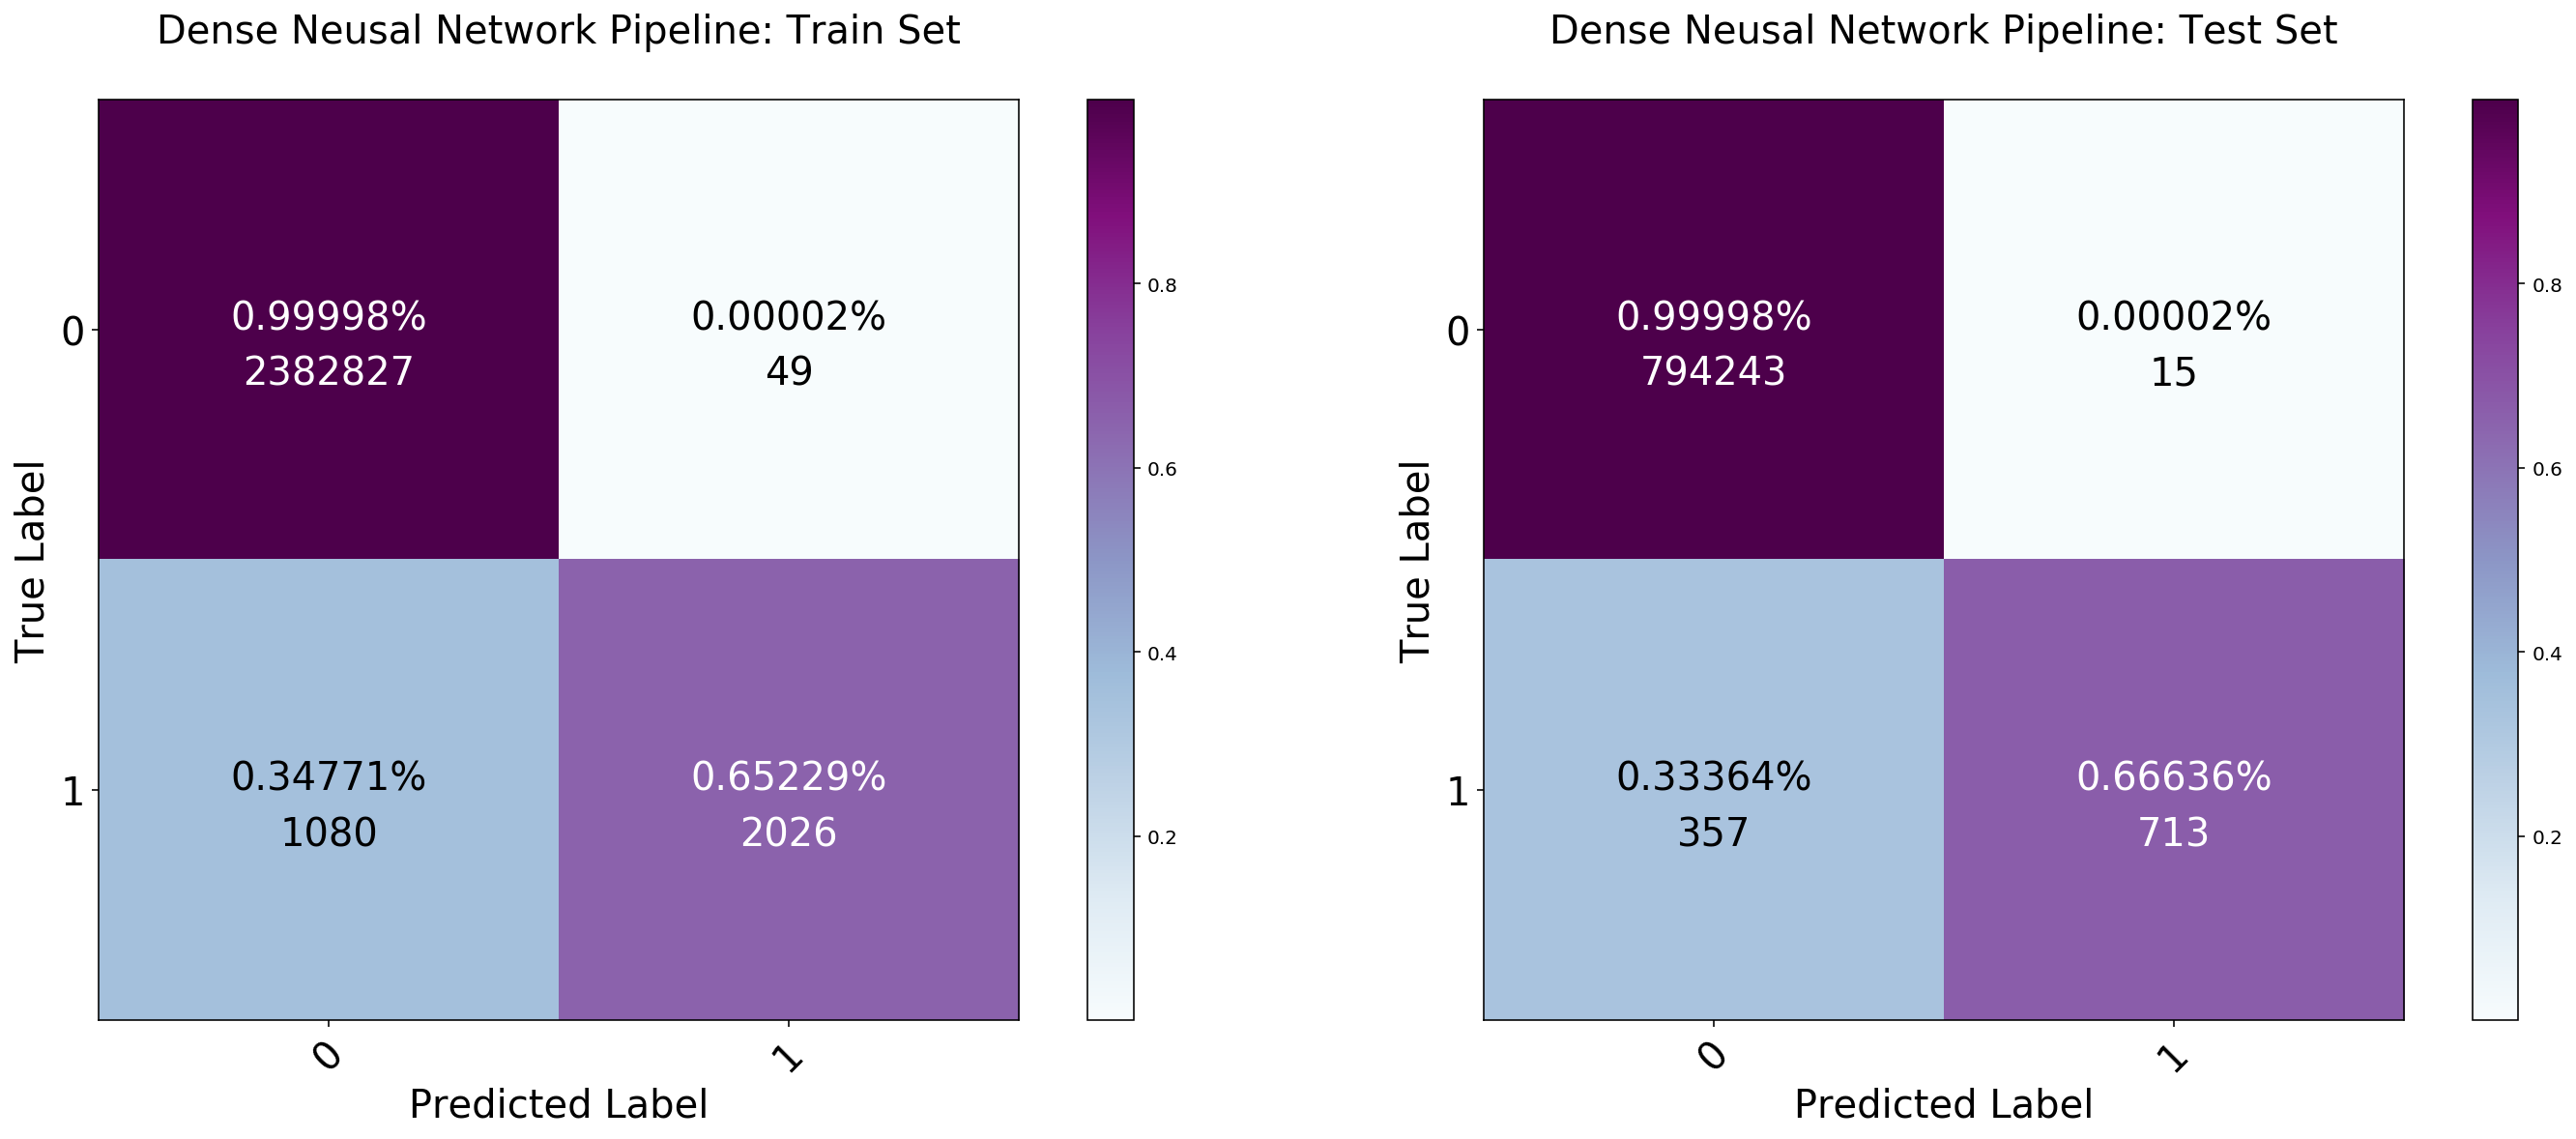

In [14]:
%%time
plot_confusion_normal(model=nn_pipeline, classes=[0,1], 
                      name = 'Dense Neusal Network Pipeline',
                      train_x=X_train, train_y=y_train,
                      test_x=X_test ,test_y=y_test,
                      cmap= plt.cm.BuPu)

In [15]:
# View nn model Scores
nn_score_df = pd.DataFrame(nn_scores).T
nn_score_df['Mean'] = nn_score_df.mean(axis=1)
nn_score_df['Mean']

fit_time          53.179
score_time        19.024
test_accuracy      0.999
train_accuracy     0.999
test_precision     0.928
train_precision    0.927
test_recall        0.621
train_recall       0.625
test_f1            0.743
train_f1           0.746
test_roc_auc       0.988
train_roc_auc      0.989
Name: Mean, dtype: float64

In [16]:
#def create_model():
#    model = Sequential()
#    model.add(layers.Dense(128, activation='relu', input_shape=(10,),
#                          name='Dense_Layer_1'))
#    model.add(layers.Dense(64, activation='relu',
#                          name='Dense_Layer_2'))
#    model.add(layers.Dense(1, activation='sigmoid',
#                          name='Softmax_Layer'))
#    model.compile(optimizer='adam',
#             loss='binary_crossentropy',
#             metrics=['accuracy'])
#    return model
#
#
#nn_model = KerasClassifier(build_fn=create_model, 
#                           nb_epoch=10, verbose=0)
#
#nn_pipeline = make_pipeline(PCA(n_components=10),StandardScaler(),
#                             nn_model)
#
#
#nn_scores = cross_validate(nn_pipeline, X_train, y_train, cv=5, 
#                            scoring=['accuracy','precision','recall',
#                                     'f1','roc_auc'],)
#
#nn_pipeline.fit(X_train,y_train, **{'kerasclassifier__nb_epoch':5})
#
# Save Pipeline
#joblib.dump(nn_pipeline, 'Models/fraud_nn_pipeline.sav')
#
#plot_confusion_normal(model=nn_pipeline, classes=[0,1], 
#                      name = 'Dense Neusal Network Pipeline',
#                      train_x=X_train, train_y=y_train,
#                      test_x=X_test ,test_y=y_test,
#                      cmap= plt.cm.BuPu)

In [17]:
%%time
# Encode all object colunms to categorical codes
sdf_holdout.type = sdf_holdout.type.astype('category').cat.codes
sdf_holdout.nameorig = sdf_holdout.nameorig.astype('category').cat.codes
sdf_holdout.namedest = sdf_holdout.namedest.astype('category').cat.codes

# Drop is flagged false column
sdf_holdout = sdf_holdout.drop('isflaggedfraud', axis=1)

# Concatenate one-hot encoded type features
sdf_holdout = pd.concat([sdf_holdout,pd.get_dummies(sdf_holdout.type, 'type', drop_first=True)], axis=1).drop('type',axis=1)

X_holdout = sdf_holdout.drop('target', axis=1).values
y_holdout = sdf_holdout.target.values

Wall time: 17.4 s


In [18]:
%%time
nn_hold = nn_pipeline.predict(X_holdout)

Wall time: 29.9 s


In [20]:
%%time
print('nn Pipeline holdout ROC AUC Score:',roc_auc_score(y_holdout, nn_hold))
print('nn Pipeline holdout F1 Score:',f1_score(y_holdout, nn_hold), '\n')

print('nn Pipeline test ROC AUC Score:',roc_auc_score(y_test, nn_pipeline.predict(X_test)))
print('nn Pipeline test F1 Score:',f1_score(y_test, nn_pipeline.predict(X_test)), '\n')

#print('ee Pipeline ROC AUC Score:',precision_score(y_test, ee_pipeline.predict(X_test)))
#print('ee Pipeline ROC AUC Score:',recall_score(y_test, ee_pipeline.predict(X_test)))
print('nn Pipeline train ROC AUC Score:',roc_auc_score(y_train, nn_pipeline.predict(X_train)))
print('nn Pipeline train F1 Score:',f1_score(y_train, nn_pipeline.predict(X_train)), '\n')
#print('ee Pipeline ROC AUC Score:',roc_auc_score(y_holdout, ee_pipline.predict(X_holdout)))
#print('ee Pipeline F1 Score:',f1_score(y_holdout, ee_pipline.predict(X_holdout)), '\n')

nn Pipeline holdout ROC AUC Score: 0.8259711084426417
nn Pipeline holdout F1 Score: 0.7792746113989637 

nn Pipeline test ROC AUC Score: 0.8331681273179367
nn Pipeline test F1 Score: 0.7931034482758621 

nn Pipeline train ROC AUC Score: 0.8261326674375002
nn Pipeline train F1 Score: 0.7820883999227948 

Wall time: 1min 1s
